# Prepare points of interest (POI) data for bicycle networks analysis
## Project: Bicycle network analysis with Gourab, Sayat, Tyler, Michael, Roberta

This notebook downloads and prepares points of interest data to be used for bicycle network design, snapping them to the networks created in 01_prepare_networks:
* railway stations/halts and bus stops
* high population density points
* grid points

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-07-07  
Last modified: 2020-07-07

## Preliminaries

### Imports and magics

In [87]:
import osmnx as ox
import networkx as nx
import watermark
import numpy as np

import fiona
import shapely
import gdal
import osr

import pprint
import sys
pp = pprint.PrettyPrinter(indent=4)

%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [9]:
%watermark -n -v -m -g -iv

fiona     1.8.13
watermark 2.0.2
networkx  2.4
shapely   1.7.0
osmnx     0.13.0
Tue Jul 07 2020 

CPython 3.8.2
IPython 7.14.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


### Parameters

In [143]:
datapath = "../data/"
densityfolder = "populationdensity"

# dict of placeid:placeinfo
# If a city has a proper shapefile through nominatim
# In case no (False), manual download of shapefile is necessary, see below
cities = {#'london': "greater london",
          #'bogota': "bogota, colombia",
          #'manhattan': "manhattan",
          #'budapest': {"nominatimstring": "Budapest, Hungary", "countryid": "hun"},
          #'paris':"Paris, France",
          #'paris_grand': "Métropole du Grand Paris",
          'copenhagen': {"nominatimstring": False, "countryid": "dnk"}
         } 

osmnxparameters = {'car30':{'network_type':'drive', 'custom_filter':'["maxspeed"~"30"]'},
                   'carall':{'network_type':'drive', 'custom_filter':''}
                  }  

# We get all the railway stations/halts (including metro) and bus stops
poiparameters = {"railwaystation":{'railway':['station','halt']}#,
                 #"busstop":{'highway':'bus_stop'}
                }

To check for nominatimstring:
* Go to e.g. https://nominatim.openstreetmap.org/search.php?q=paris%2C+france&polygon_geojson=1&viewbox= and enter the search string. If a correct polygon (or multipolygon) pops up it should be fine.

To get shapefiles:
* Go to [Overpass](overpass-turbo.eu), to the city, and run:
    `relation["boundary"="administrative"]["name:en"="Copenhagen Municipality"]({{bbox}});(._;>;);out skel;`
* Export: Download as GPX
* Use QGIS to create a polygon, with Vector > Join Multiple Lines, and Processing Toolbox > Polygonize (see https://gis.stackexchange.com/questions/98320/connecting-two-line-ends-in-qgis-without-resorting-to-other-software and https://gis.stackexchange.com/questions/207463/convert-a-line-to-polygon)

## Download and wrangle data

### Railway stations/halts and bus stops

In [ ]:
for placeid, placeinfo in cities.items():
    if placeinfo["nominatimstring"]:
        location = ox.gdf_from_place(placeinfo["nominatimstring"])
        location = shapely.geometry.shape(location['geometry'][0])
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(datapath+placeid+".shp")
        first = shp.next()
        location = shapely.geometry.shape(first['geometry'])
    
    cities[placeid]["bbox"] = location.bounds
    
    # We need the carall graph
    parameterdict = osmnxparameters['carall']
    G = ox.graph_from_polygon(location, 
                               network_type = parameterdict['network_type'],
                               custom_filter = (parameterdict['custom_filter']),
                               retain_all = True,
                               simplify = False)
    
    for poiid, poitag in poiparameters.items():
        gdf = ox.pois.pois_from_polygon(location, tags = poitag)
        gdf = gdf[gdf['geometry'].type == "Point"] # only consider points, no polygons etc
        # Now snap to closest nodes in street network, save the nearest node ids
        nnids = ox.distance.get_nearest_nodes(G, gdf['geometry'].x, gdf['geometry'].y)
        with open(datapath+placeid+'_'+'poi_'+poiid+'_nnidscarall.csv', 'w') as f:
            for item in nnids:
                f.write("%s\n" % item)
        
        gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
        try: # For some cities writing the gdf does not work (i.e. London, New York)
            gdf.to_file(datapath+placeid+'_'+'poi_'+poiid+'.gpkg', driver='GPKG')
        except:
            pass
        gdf.plot(color='red')
    cities[placeid]["bbox"] = location.bounds

### Population density

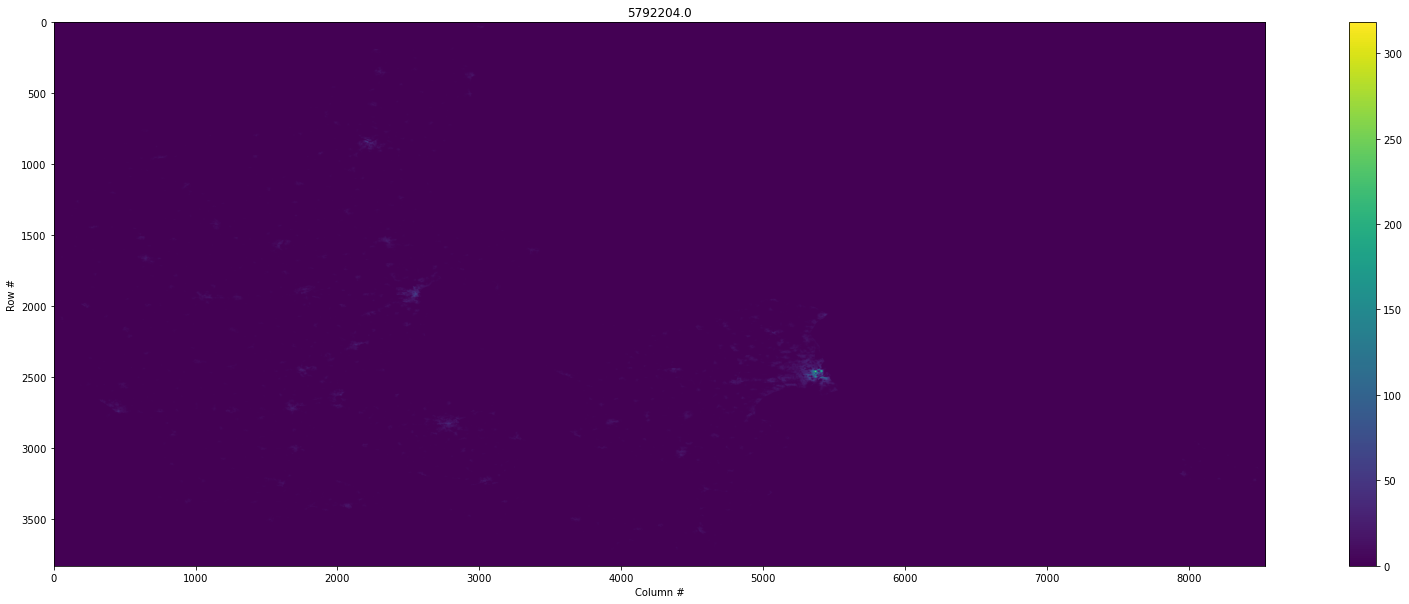

In [144]:
# https://medium.com/@danielmoyo/raster-data-in-python-part-i-reading-and-visualising-raster-data-95cb072fcbfa
import rasterio
import matplotlib.pyplot as plt

for placeid, placeinfo in cities.items():
    raster_path = datapath + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
    pop_raster = rasterio.open(raster_path)
    
    cities[placeid]["bbox"] = location.bounds

    def plot_raster(arr, title=None, figsize=(30,10)):
        """ helper function to plot a raster array """
        fig, ax = plt.subplots(figsize=figsize)
        plt.imshow(arr)
        plt.colorbar()
        plt.title(f'{title}')
        plt.xlabel('Column #')
        plt.ylabel('Row #')
        return fig, ax

    pop_data = pop_raster.read(1)
    pop_data[pop_data<0] = 0
    pop_count = pop_data[pop_data>0].sum()
    plot_raster(pop_data, title=pop_count)

In [147]:
# https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# https://gdal.org/api/gdaldataset_cpp.html#_CPPv4N11GDALDataset15GetGeoTransformEPd

# Problems:
# https://gis.stackexchange.com/questions/331908/notimplementederror-wrong-number-or-type-of-arguments-for-overloaded-function
# https://gis.stackexchange.com/questions/44040/osr-python-testsr-importfromepsg4326-returns-empty-spatial-reference
# https://www.programcreek.com/python/example/58591/osgeo.osr.SpatialReference


def generate_latlons(raster_path):
    # open the dataset and get the geo transform matrix
    ds = gdal.Open(raster_path) 
    xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()
    ds_arr = ds.ReadAsArray()
    
    x_arr = np.arange(0, ds_arr.shape[0], 1)
    x_arr.shape = (len(x_arr), 1)
    x_arr = np.repeat(x_arr, [ds_arr.shape[1]], axis=1)
    
    y_arr = np.arange(0, ds_arr.shape[1], 1)
    y_arr.shape = (1, len(y_arr))
    y_arr = np.repeat(y_arr, [ds_arr.shape[0]], axis=0)
    
    # supposing x and y are your pixel coordinate this 
    # is how to get the coordinate in space.
    lon_arr = xoffset + px_w * y_arr + rot1 * x_arr + px_w / 2.0
    lat_arr = yoffset + px_h * y_arr + rot2 * x_arr + px_h / 2.0
    
    return(lat_arr, lon_arr)

for placeid, placeinfo in cities.items():
    raster_path = datapath + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
    pop_raster = rasterio.open(raster_path)
    (lat, lon) = generate_latlons(raster_path)
    
# To do: only read the relevant window
# https://medium.com/@danielmoyo/raster-data-in-python-part-ii-working-with-geographic-coordinates-a368708de5f2

2459 5366
55.702916645247655 12.54833329874031


(<Figure size 2160x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fce0bcb22e0>)

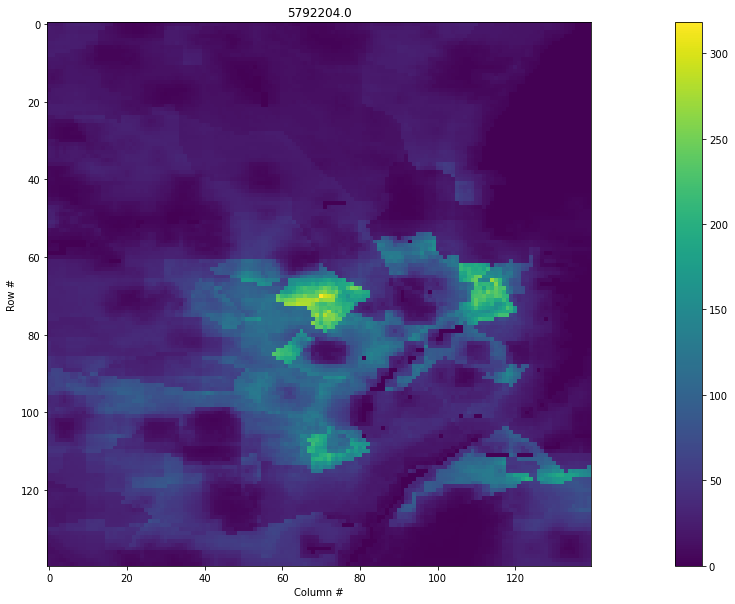

In [150]:
indices = np.where(pop_data == pop_data.max())
c_x = indices[0].item()
c_y = indices[1].item()

delta = 70
plot_raster(pop_data[c_x-delta:c_x+delta, c_y-delta:c_y+delta], title=pop_count)

### Grid